<a href="https://colab.research.google.com/github/kkmax1015/Kaggle/blob/main/Titanic/3_%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1%E6%96%B9%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Googleドライブへのマウント
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Titanic/'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Titanic
1_SampleNoteBook_LogisticRegression	  3_モデルの評価方法.ipynb  output
2_欠損値とカテゴリー変数の取り扱い.ipynb  data


# 目標：Submit無しである程度モデルの評価を行うことが可能となる

過去2回はトレーニングデータで学習させたモデルの精度はテストデータの予測をKaggleへ提出することで精度を確認した。

今後、更なる精度向上をする為にモデルの改修を行っていくが、この際にテストデータのスコアを見ながらモデルを回収していくのは適切な手段ではない。

機械学習モデルの最終的な目標は未知のデータを予測することで、テストデータは未知のデータのサンプルとして与えられているものとなる。この未知のデータであるテストデータの精度を見ながらモデルの精度を評価することは、結局テストデータ「だけ」を上手く予測するモデルを作成していることになり、適切ではない。

その為、テストデータはあくまで最終的な精度の確認に用いるデータという扱いにし、モデルを試行錯誤する際に用いるデータは別途用意する必要がある。

###１.ホールドアウト検証によるモデルの評価

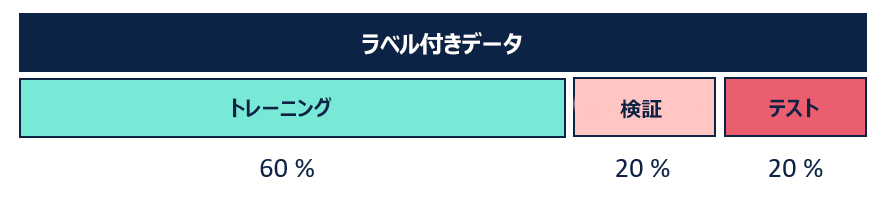

ホールドアウト検証はデータ全体をトレーニング・検証(Validation)・テストの3つに分割する手法。

モデルの学習はトレーニングで行い、精度改善する為の試行錯誤は検証データでの精度を見ながら実施していく。

Kaggleの場合、提供されているテストデータが上図の「テスト」の部分に相当する。その為、トレーニングデータを「トレーニング」、「検証」に分割し、モデルの評価を行っていく。

トレーニングデータと検証データの割合に絶対的な正解はないが、概ね８：２や７：３に分割されることが多い。

In [65]:
# 必要なライブラリをImportする
import pandas as pd
import numpy as np

# CSVデータをPandasデータフレームへ読み込む
train = pd.read_csv("./data/train.csv");
test = pd.read_csv("./data/test.csv");
submit = pd.read_csv("./data/gender_submission.csv");

In [66]:
# それぞれのデータの件数を算出する
print(len(train), len(test),len(submit))

891 418 418


In [67]:
# トレーニング用データの先頭5行を表示
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
# テスト用データの先頭5行を表示
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [69]:
# トレーニングとテストデータのマージ
data = train.drop('Survived',axis=1)
data = pd.concat([data,test],join='inner')
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
# 第1回と第2回のデータをそれぞれ作成する
data1 = data.copy()
data2 = data.copy()

In [71]:
# 第1回のデータを作成
# 不要なカラムの削除
data1.drop(['Name','Sex','Ticket','Cabin','Embarked','Age','Fare'],axis = 1,inplace=True)
y_data1 = train['Survived']
X_data1 = data1[:len(train)]
X_test1 = data1[len(train):]
X_data1.head()

,PassengerId,Pclass,SibSp,Parch
0,1,3,1,0
1,2,1,1,0
2,3,3,0,0
3,4,1,1,0
4,5,3,0,0


In [72]:
# 第2回のデータを作成
# 不要なカラムの削除
data2.drop(['PassengerId','Name','Ticket','Cabin'],axis = 1,inplace=True)

# 欠損値の補完
data2['Age'].fillna(data['Age'].median(), inplace=True)
data2['Fare'].fillna(np.mean(data['Fare']), inplace=True)
data2['Embarked'].fillna('S', inplace=True)

# カテゴリー変数の変換
data2['Sex'].replace(['male','female'], [0, 1], inplace=True)
data2['Embarked'].replace(['S','C','Q'], [0, 1, 2], inplace=True)

y_data2 = train['Survived']
X_data2 = data2[:len(train)]
X_test2 = data2[len(train):]
X_data2.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,3,0,35.0,0,0,8.0500,0


今回はトレーニングデータを８：２に分割し、トレーニングデータで学習したモデルが検証データに対しどの程度の精度を出すのか確認する。この分割はsklearnのtrain_test_splitを使用して簡単に実現できる。使用時、特に気にするべき引数は以下の3つ。

test_size：テストデータの割合を指定する。今回は２割とするので、0.2を指定している。

stratify：層化抽出を実施するかどうかを制御するパラメーター。目的変数を指定することで、トレーニングデータと検証データに含まれるデータの正解ラベルの分布を同じにすることが出来る。

random_state：疑似乱数を固定する。これを指定しておかないと実行ごとに毎回異なるデータセットが作成されてモデルの比較が行えなくなる（再現性が失われる）ので、指定を行う。

In [73]:
# トレーニングデータ、検証データの分割
from sklearn.model_selection import train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_data1, y_data1, test_size=0.2, random_state=42, stratify=y_data1,shuffle = True)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_data2, y_data2, test_size=0.2, random_state=42, stratify=y_data2,shuffle = True)

print(len(X_train1), len(X_val1))
print(len(X_train2), len(X_val2))

712 179
712 179


In [74]:
# 今回は第1回と第2回の比較をしたいので同じ分割がされているかも確認する。
X_train1.head()

,PassengerId,Pclass,SibSp,Parch
692,693,3,0,0
481,482,2,0,0
527,528,1,0,0
855,856,3,0,1
801,802,2,1,1


In [75]:
X_train2.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
692,3,0,28.0,0,0,56.4958,0
481,2,0,28.0,0,0,0.0000,0
527,1,0,28.0,0,0,221.7792,0
855,3,1,18.0,0,1,9.3500,0
801,2,1,31.0,1,1,26.2500,0


In [76]:
# sklearnのロジスティック回帰をImport
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルの作成(初期化)
# random_state：初期化パラメータ。指定することで学習結果を固定することが出来る。
clf1 = LogisticRegression(random_state=0)
clf2 = LogisticRegression(random_state=0)

In [77]:
# 第1回、第2回のデータを用いてそれぞれモデルを作成する。
clf1.fit(X_train1,y_train1)
clf2.fit(X_train2,y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
# 学習したモデルでそれぞれトレーニングデータ、検証データに対する正答率を確認する。
print(f'Training score(data1)：{clf1.score(X_train1, y_train1):.5f}')
print(f'Validation score(data1)：{clf1.score(X_val1, y_val1):.5f}')
print('\n')
print(f'Training score(data2)：{clf2.score(X_train2, y_train2):.5f}')
print(f'Validation score(data2)：{clf2.score(X_val2, y_val2):.5f}')

Training score(data1)：0.69803
Validation score(data1)：0.64804


Training score(data2)：0.80478
Validation score(data2)：0.80447


基本的にトレーニングデータに対する精度は検証データに対する精度よりも高く出る。これはモデルが学習済み（一度解いた問題）だからであり、未知のデータ（初見の問題）より高く出るのが通常となる。もし逆転してしまっている場合には、ソースコードに何らかのミスがある可能性がある為、チェックしたほうが良い。

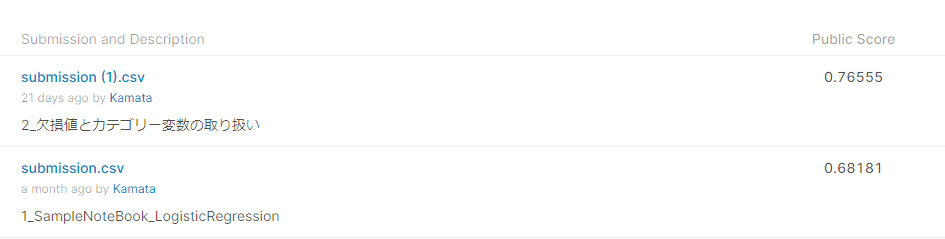

実際にKaggleに提出したテストデータのスコアと検証データのスコアを見比べると、やや乖離は発生しているがいるが、今回ランダムに分割したデータにおいて、検証データのスコアを上げることが出来ればテストデータのスコアについても上がりそうであると仮説を立てられる。

その為、検証データのスコアを指標としてモデルの改修を行えば良さそうだと方針を立てることが出来る。

In [79]:
# 試しに第2回のデータを用いて他のアルゴリズムを使用して検証データのスコアとテストデータのスコアを見てみる。
# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier(n_estimators=50,random_state=42)
clf3.fit(X_train2,y_train2)

print(f'Training score(RF-50)：{clf3.score(X_train2, y_train2):.5f}')
print(f'Validation score(RF-50)：{clf3.score(X_val2, y_val2):.5f}')

clf4 = RandomForestClassifier(n_estimators=100,random_state=42)
clf4.fit(X_train2,y_train2)
print('\n')
print(f'Training score(RF-100)：{clf4.score(X_train2, y_train2):.5f}')
print(f'Validation score(RF-100)：{clf4.score(X_val2, y_val2):.5f}')

clf5 = RandomForestClassifier(n_estimators=200,random_state=42)
clf5.fit(X_train2,y_train2)
print('\n')
print(f'Training score(RF-200)：{clf5.score(X_train2, y_train2):.5f}')
print(f'Validation score(RF-200)：{clf5.score(X_val2, y_val2):.5f}')

Training score(RF-50)：0.98174
Validation score(RF-50)：0.79888


Training score(RF-100)：0.98174
Validation score(RF-100)：0.81564


Training score(RF-200)：0.98174
Validation score(RF-200)：0.82123


ランダムフォレストの決定木の数を増やしていくと、検証データのスコアが上がっていくことが分かる。決定木を増やすほど、汎化性能が向上しテストデータについても未知のデータ（テストデータ）への精度も良くなると思われるため、Kaggleに提出してみる。

In [80]:
y_pred3 = clf3.predict(X_test2)
y_pred4 = clf4.predict(X_test2)
y_pred5 = clf5.predict(X_test2)
sub = submit
sub['Survived'] = y_pred3
sub.to_csv('./output/submission_RF-50.csv', index=False)
sub['Survived'] = y_pred4
sub.to_csv('./output/submission_RF-100.csv', index=False)
sub['Survived'] = y_pred5
sub.to_csv('./output/submission_RF-200.csv', index=False)

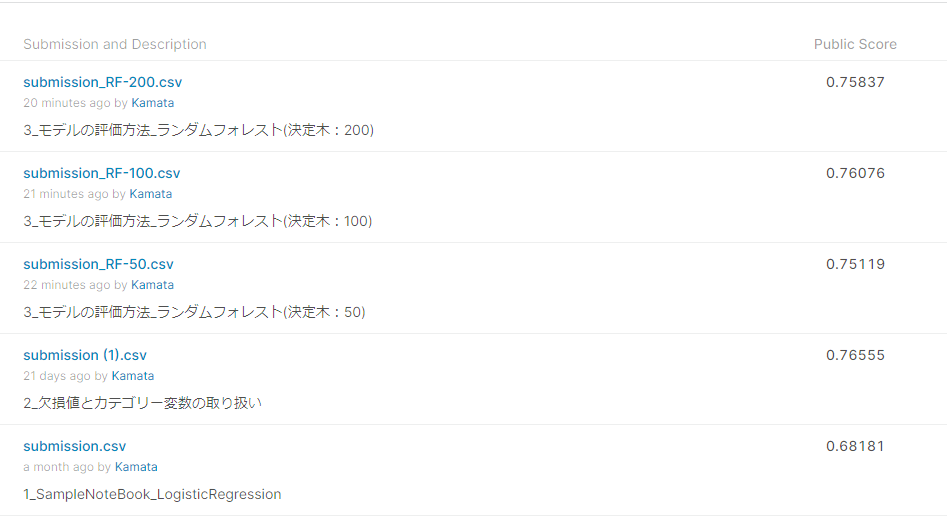

すると、期待に反してテストデータのスコアが検証スコアと一致していないことが確認できる。こうした状態のまま検証スコアを上げていってもモデルの汎化性能が向上せず、過学習してしまう可能性がある為、信頼できる検証スコアを手元に構築することが重要となる。

乖離してしまう理由は多岐にわたるが、例としてはテストデータと検証データのデータ分布が違う等データの中身に起因するケースや、そもそも検証データの切り方が不適切（例えばトレーニングと検証の割合や、層化抽出を忘れてしまった等）であることが考えられる為、これらを考慮しながら信頼できる検証スコアを模索する必要がある。

###２.クロスバリデーションによるモデルの評価

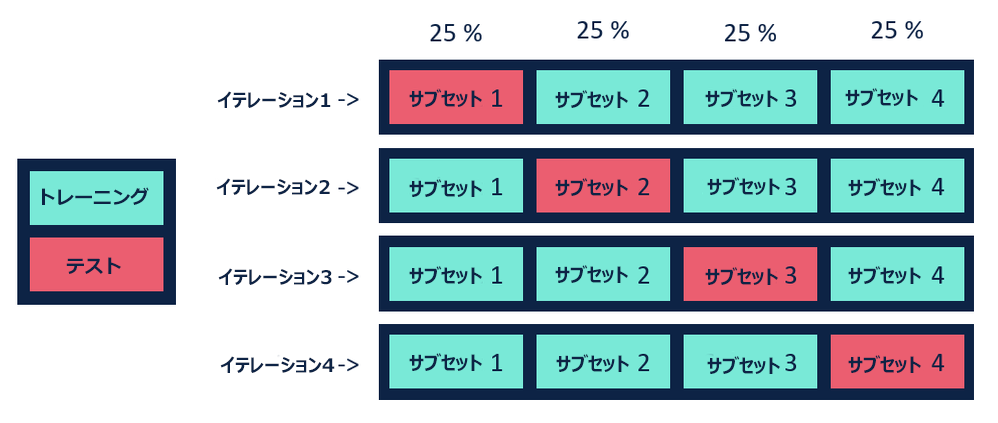

ホールドアウト検証ではバリデーションデータを学習に使用することが出来ず、全てのデータを効率的に使用できないという欠点がある。学習に使用できるデータが大量に存在する場合はあまり問題にならないが、今回のようにデータが少ない場合は出来るだけ多くのデータを学習に回したい。

クロスバリデーションは上図のように、ホールドアウト検証を複数回繰り返していくことで、検証データの量を確保しつつ全てのデータを学習に回した場合のスコアを確認することが出来る。（上図「テスト」がホールドアウトの検証に相当する。）

最終的なモデルの評価は、各回（イテレーション1～4）の検証スコアの平均値で評価を行う。

In [81]:
# 第2回のデータを用いて作成したモデルをクロスバリデーションで評価する。
# sklearnにはクロスバリデーション用のライブラリとして「KFold」と「StratifiedKFold」があるが、今回は層化抽出を行ってくれるStratifiedKFoldを使用する。
from sklearn.model_selection import StratifiedKFold

# 層化抽出による分割
# n_splitsで何分割するのかを指定する。今回は5分割する。
# 5分割・・・892÷5 = 178.2　となる為、バリデーションの比率はホールドアウトの8:2と変わらない。
# 5分割することで、バリデーションの比率を2割に保ちつつ、新たに178件のデータをトレーニングへ加えることとなる。
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

# 5回分のスコアを入れる配列を用意
scores = []


# 5回学習
for train_index, val_index in skf.split(X_data2, y_data2):
  X_train, X_val = X_data2.iloc[train_index], X_data2.iloc[val_index]
  y_train, y_val = y_data2.iloc[train_index], y_data2.iloc[val_index]

  # 学習モデルは毎回初期化する（重要）
  clf6 = LogisticRegression(random_state=0)
  clf6.fit(X_train,y_train)

  # スコアを配列に格納
  scores.append(clf6.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [82]:
# 配列の中身を表示
print(scores)

# 平均値を表示
print(f'Cross Validation score：{np.mean(scores):.5f}')

[0.776536312849162, 0.8033707865168539, 0.7865168539325843, 0.7808988764044944, 0.8146067415730337]
Cross Validation score：0.79239


各回の検証スコアを見るとばらつきがあり、検証データの切り方によりスコアが変わってしまうことが分かる。

最終的なスコアは平均値である0.79239となる。ホールドアウトに比べて若干下がったが、Kaggleのテストスコアに近づいており、クロスバリデーションにより検証スコアの信頼性が上昇したことが期待できる。

In [83]:
# ランダムフォレストで試してみる
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

scores_50 = []
scores_100 = []
scores_200 = []

# 5回学習
for train_index, val_index in skf.split(X_data2, y_data2):
  X_train, X_val = X_data2.iloc[train_index], X_data2.iloc[val_index]
  y_train, y_val = y_data2.iloc[train_index], y_data2.iloc[val_index]

  # 学習
  clf7 = RandomForestClassifier(n_estimators=50,random_state=42)
  clf8 = RandomForestClassifier(n_estimators=100,random_state=42)
  clf9 = RandomForestClassifier(n_estimators=200,random_state=42)
  clf7.fit(X_train,y_train)
  clf8.fit(X_train,y_train)
  clf9.fit(X_train,y_train)

  # スコアを配列に格納
  scores_50.append(clf7.score(X_val, y_val))
  scores_100.append(clf8.score(X_val, y_val))
  scores_200.append(clf9.score(X_val, y_val))

In [84]:
# 配列の中身を表示
print(scores_50)
print(scores_100)
print(scores_200)

# 平均値を表示
print(f'Cross Validation score(RF50)：{np.mean(scores_50):.5f}')
print(f'Cross Validation score(RF100）：{np.mean(scores_100):.5f}')
print(f'Cross Validation score(RF200)：{np.mean(scores_200):.5f}')

[0.8435754189944135, 0.8146067415730337, 0.7921348314606742, 0.8089887640449438, 0.8539325842696629]
[0.8435754189944135, 0.8146067415730337, 0.7752808988764045, 0.8146067415730337, 0.8426966292134831]
[0.8379888268156425, 0.8089887640449438, 0.7865168539325843, 0.8089887640449438, 0.8314606741573034]
Cross Validation score(RF50)：0.82265
Cross Validation score(RF100）：0.81815
Cross Validation score(RF200)：0.81479


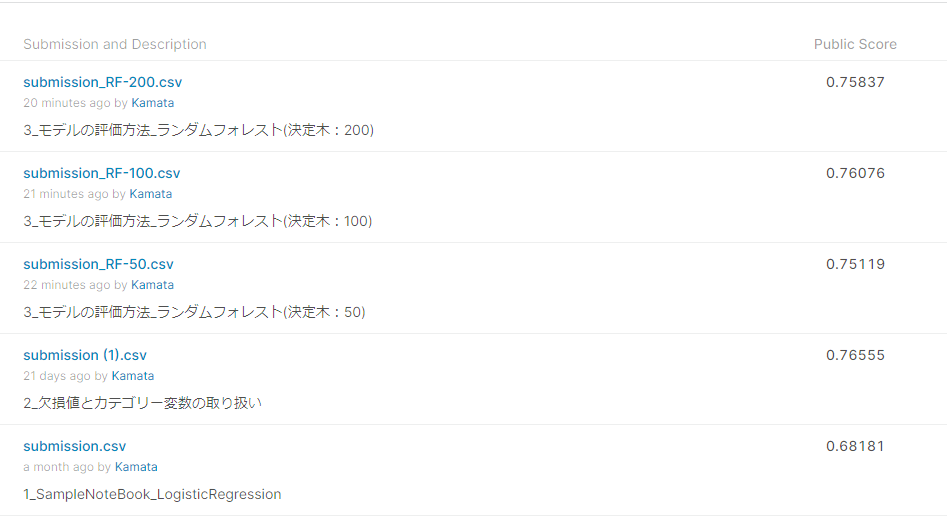

ランダムフォレストの場合、テストスコアでは決定木が100の場合が最も高いが、検証スコアでは50の場合が高くなってしまっており、やはり信頼性に疑問が残る状態となってしまっている。

クロスバリデーションの各回のスコアを見るとかなり高くスコアが出ている回があり、一部のデータに過剰に適合していることが疑われるので検証データの割合を増やしてみる。

In [85]:
# 3分割へ設定
# 892÷3 = 297.3件が検証データとなる。
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle = True)

scores_50 = []
scores_100 = []
scores_200 = []

for train_index, val_index in skf.split(X_data2, y_data2):
  X_train, X_val = X_data2.iloc[train_index], X_data2.iloc[val_index]
  y_train, y_val = y_data2.iloc[train_index], y_data2.iloc[val_index]

  # 学習
  clf7 = RandomForestClassifier(n_estimators=50,random_state=42)
  clf8 = RandomForestClassifier(n_estimators=100,random_state=42)
  clf9 = RandomForestClassifier(n_estimators=200,random_state=42)
  clf7.fit(X_train,y_train)
  clf8.fit(X_train,y_train)
  clf9.fit(X_train,y_train)

  # スコアを配列に格納
  scores_50.append(clf7.score(X_val, y_val))
  scores_100.append(clf8.score(X_val, y_val))
  scores_200.append(clf9.score(X_val, y_val))

In [86]:
# 配列の中身を表示
print(scores_50)
print(scores_100)
print(scores_200)

# 平均値を表示
print(f'Cross Validation score(RF50)：{np.mean(scores_50):.5f}')
print(f'Cross Validation score(RF100）：{np.mean(scores_100):.5f}')
print(f'Cross Validation score(RF200)：{np.mean(scores_200):.5f}')

[0.8181818181818182, 0.797979797979798, 0.8249158249158249]
[0.8215488215488216, 0.8047138047138047, 0.8215488215488216]
[0.8215488215488216, 0.8013468013468014, 0.8215488215488216]
Cross Validation score(RF50)：0.81369
Cross Validation score(RF100）：0.81594
Cross Validation score(RF200)：0.81481


検証データの割合を変えることで、テストスコアの傾向へ近づいた（精度が決定木100 > 200 > 50）。

５分割の時より検証スコアの信頼性が上昇したことが期待できる。